In [2]:
import torch
import torch_geometric
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import yaml

with open('definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

In [4]:
from GraphDataset import GraphDataset
# file_names = ['root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root']
file_names=["/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_10.root"]
graph_dataset = GraphDataset('data', features, labels, spectators, n_events=10000, n_events_merge=1000, 
                             file_names=file_names)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, global_mean_pool
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer

class EdgeBlock(torch.nn.Module):
    def __init__(self):
        super(EdgeBlock, self).__init__()
        self.edge_mlp = Seq(Lin(48*2, 128), 
                            ReLU(),
                            Lin(128, 128))

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest], 1)
        return self.edge_mlp(out)

class NodeBlock(torch.nn.Module):
    def __init__(self):
        super(NodeBlock, self).__init__()
        self.node_mlp_1 = Seq(Lin(48+128, 128), 
                              ReLU(), 
                              Lin(128, 128))
        self.node_mlp_2 = Seq(Lin(48+128, 128), 
                              ReLU(), 
                              Lin(128, 128))

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)

    
class GlobalBlock(torch.nn.Module):
    def __init__(self):
        super(GlobalBlock, self).__init__()
        self.global_mlp = Seq(Lin(128, 128), 
                              ReLU(), 
                              Lin(128, 2))

    def forward(self, x, edge_index, edge_attr, u, batch):
        out = scatter_mean(x, batch, dim=0)
        return self.global_mlp(out)


class InteractionNetwork(torch.nn.Module):
    def __init__(self):
        super(InteractionNetwork, self).__init__()
        self.interactionnetwork = MetaLayer(EdgeBlock(), NodeBlock(), GlobalBlock())
    
    def forward(self, x, edge_index, batch):
        x, edge_attr, u = self.interactionnetwork(x, edge_index, None, None, batch)
        return u,edge_attr

In [6]:
@torch.no_grad()
def test(model,loader,total,batch_size):
    model.eval()
    
    xentropy = nn.CrossEntropyLoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        y = torch.argmax(data.y,dim=1)
        batch_output = model(data.x, data.edge_index, data.batch)
        batch_loss_item = xentropy(batch_output, y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size):
    model.train()
    
    xentropy = nn.CrossEntropyLoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        y = torch.argmax(data.y,dim=1)
        optimizer.zero_grad()
        batch_output = model(data.x, data.edge_index, data.batch)
        batch_loss = xentropy(batch_output, y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [7]:
from torch_geometric.data import Data, DataListLoader, Batch
from torch.utils.data import random_split

def collate(items):
    l = sum(items, [])
    return Batch.from_data_list(l)

torch.manual_seed(0)
valid_frac = 0.20
full_length = len(graph_dataset)
valid_num = int(valid_frac*full_length)
batch_size = 1

train_dataset, valid_dataset = random_split(graph_dataset, [full_length-valid_num,valid_num])

train_loader = DataListLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
train_loader.collate_fn = collate
valid_loader = DataListLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
valid_loader.collate_fn = collate

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)

In [8]:
model = InteractionNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [9]:
model.load_state_dict(torch.load("interactionnetwork_best.pth"))

<All keys matched successfully>

In [11]:
b=graph_dataset[0]

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import networkx as nx
from torch_geometric.utils import to_networkx
import numpy as np

def plot_graph(b,i):
    fig, ax =plt.subplots(figsize=(10,8))
    
    g=b[i]
    g.batch=torch.tensor(np.zeros(g.x.shape[0]).astype("int64"))
    g.to(device)
    u,edge_attr=model(g.x, g.edge_index, g.batch)

    edge_attr=edge_attr.detach().cpu()
    weights=edge_attr.mean(1)

    g.weights=weights

    G = to_networkx(g, edge_attrs=['weights'])

    edges,weights = zip(*nx.get_edge_attributes(G,'weights').items())
    weights=np.array(weights)
    weights-=np.min(weights)
    weights/=np.max(weights)

    pos=list(zip(g.x[:,35].detach().cpu().numpy(),g.x[:,43].detach().cpu().numpy()))
    pos=np.array(pos)

    nodes = nx.draw_networkx_nodes(G,pos,node_color='k', with_labels=False,node_size=5)
    edges = nx.draw_networkx_edges(G,pos,edge_color=weights,width=1,
                                   edge_cmap=plt.cm.Spectral, arrows=False,alpha=0.5)

    plt.colorbar(edges)
    plt.axis([-1,1,-1,1])
    
    # Change major ticks to show every 20.
    ax.xaxis.set_major_locator(MultipleLocator(1/10))
    ax.yaxis.set_major_locator(MultipleLocator(1/10))
    
    ax.grid(which='major', color='#CCCCCC', linestyle='--')

    plt.grid(True)
    plt.title(f"jet label: {g.y.detach().cpu()}")
    plt.show()

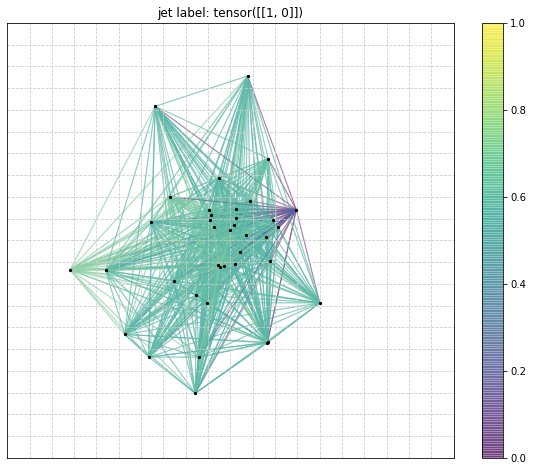

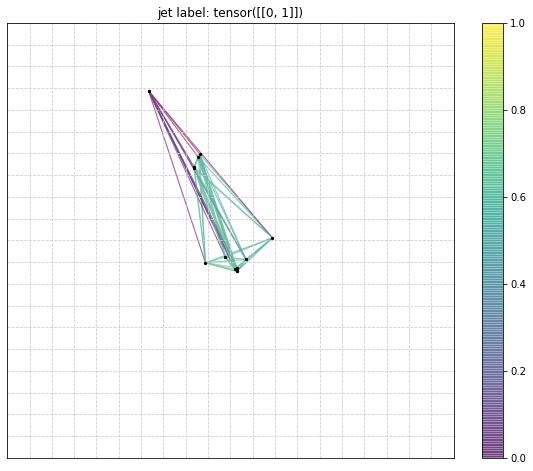

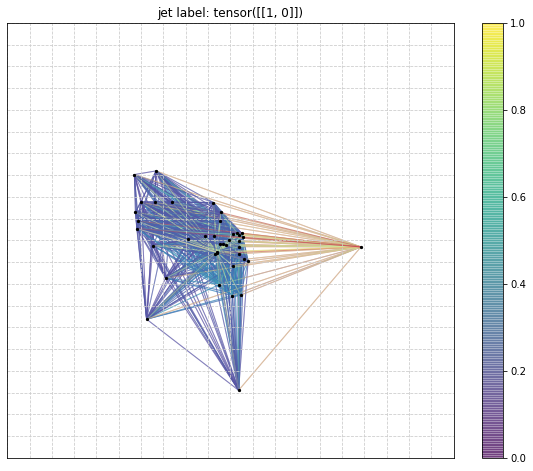

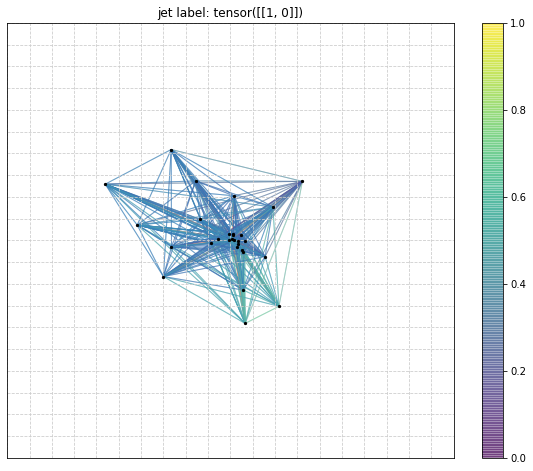

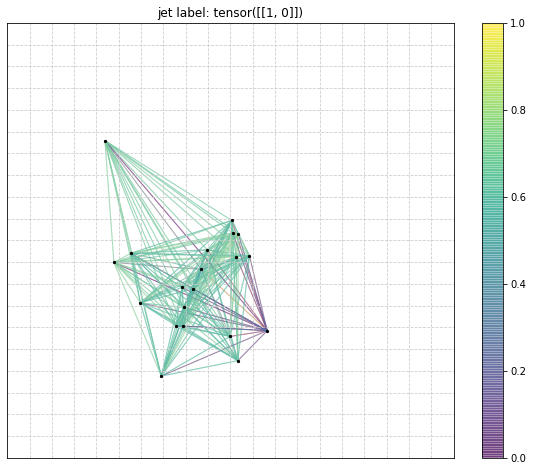

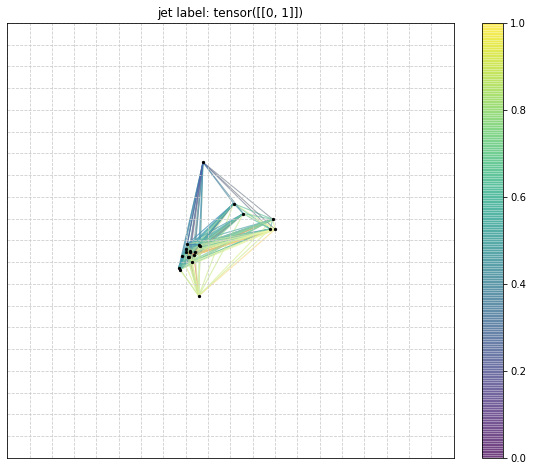

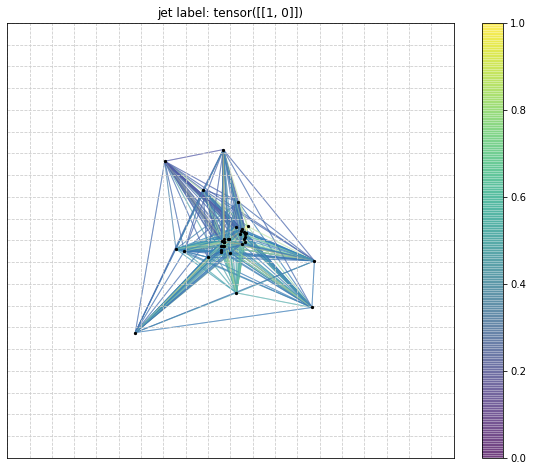

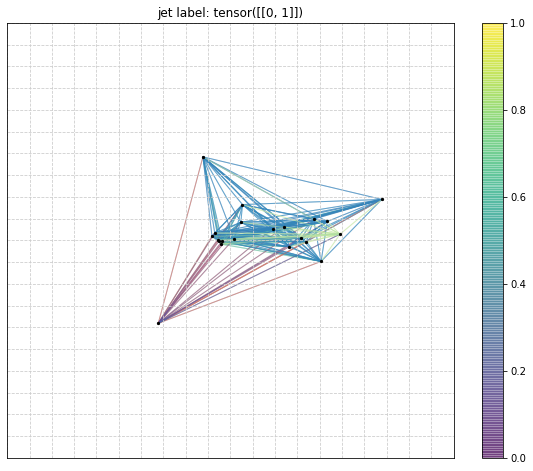

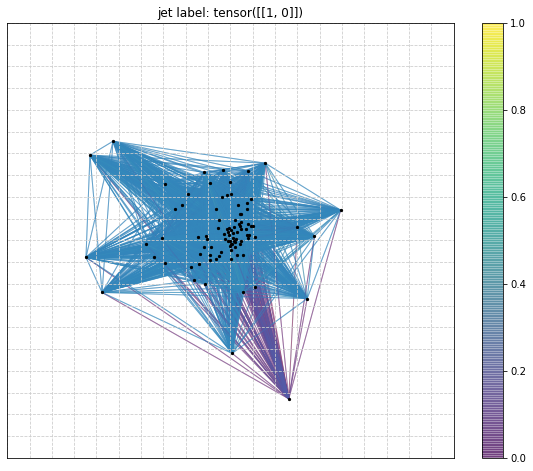

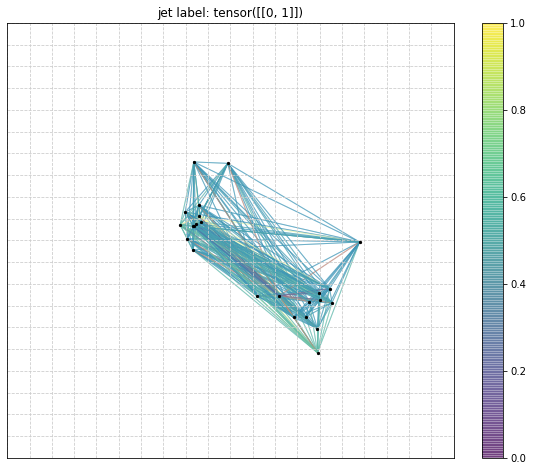

In [34]:
for i in range(10):
    plot_graph(b,i)